In [23]:
import numpy as np
import torch
import matplotlib.pyplot as plt

class LinUCB:
    def __init__(self, n_arms, context_dim, true_thetas, alphas=[1.0, 1.0]):
        self.n_arms = n_arms
        self.context_dim = context_dim
        self.alphas = alphas
        self.thetas = true_thetas
        self.t = 0 
        
        # Initialize A (identity matrices) and b (zero vectors) for each arm
        self.A = [np.identity(context_dim) for _ in range(n_arms)]
        self.b = [np.zeros(context_dim) for _ in range(n_arms)]
    
    def select_arm_ulcb(self, context, ucb=True):
        """Select the arm using the UCB policy"""
        p_values = []
        for arm in range(self.n_arms):
            A_inv = np.linalg.inv(self.A[arm])
            theta = np.dot(A_inv, self.b[arm])
            
            mean_reward = np.dot(theta, context)
            confidence = np.sqrt(np.dot(context.T, np.dot(A_inv, context)))
            if ucb:
                p_values.append(mean_reward + self.alphas[0] * confidence)
            else:
                p_values.append(max(mean_reward - self.alphas[1] * confidence, 0))
        
        return np.argmax(p_values) if ucb else np.argmax(p_values)
    
    def select_arm_greedy(self, context):
        p_values = []
        for arm in range(self.n_arms):
            A_inv = np.linalg.inv(self.A[arm])
            theta = np.dot(A_inv, self.b[arm])
            
            p_values.append(np.dot(theta, context))

        return np.argmax(p_values)
    
    def reward(self, arm, context):
        mean = np.dot(self.thetas[arm], context)
        reward = np.random.normal(loc=mean, scale=1)
        return reward
    
        
    def update(self, arm, context, reward):
        """Update A and b based on the observed reward"""
        self.A[arm] += np.outer(context, context)
        self.b[arm] += reward * context
    



In [28]:
n_arms = 100
context_dim = 5
n_iters = 50000
seed = 29
ucb_weight = .5
alphas=[1.0, 0.9]
np.random.seed(seed)
true_thetas = [np.random.randn(context_dim) for _ in range(n_arms)]
mixbandit = LinUCB(n_arms=n_arms,context_dim=context_dim,alphas=alphas, true_thetas=true_thetas)
ucbbandit = LinUCB(n_arms=n_arms,context_dim=context_dim,alphas=alphas, true_thetas=true_thetas)
greedybandit = LinUCB(n_arms=n_arms, context_dim=context_dim, alphas=alphas, true_thetas=true_thetas)
doublebandit = LinUCB(n_arms=n_arms, context_dim=context_dim, alphas=alphas, true_thetas=true_thetas)
mixrewards = []
ucbrewards = []
greedyrewards = []
doublerewards = []

for i in range(n_iters):
    if (i + 1) % 1000 == 0:
        print(f'completed {i + 1} iterations out of {n_iters}')
        # if i >= 999:
        #      ucb_weight *=.95
        if len(mixrewards) > 10:  
                print(f'current average rewards : double {np.mean(doublerewards[-10:])} -- mix {np.mean(mixrewards[-10:])} -- ucb {np.mean(ucbrewards[-10:])} -- greedy {np.mean(greedyrewards[-10:])}')
    context = np.random.randn(context_dim)
    p = np.random.uniform(0, 1)
    if p < ucb_weight:
        a_mix = mixbandit.select_arm_ulcb(context=context, ucb=True)
    else:
        a_mix = mixbandit.select_arm_ulcb(context=context, ucb=False)
    # ucb_weight *=.95
    a_ucb = ucbbandit.select_arm_ulcb(context=context, ucb=True)
    a_greedy = greedybandit.select_arm_greedy(context=context)
    r_mix = mixbandit.reward(arm=a_mix, context=context)
    r_ucb = ucbbandit.reward(arm=a_ucb, context=context)
    r_greedy = greedybandit.reward(arm=a_greedy, context=context)
    mixrewards.append(r_mix)
    ucbrewards.append(r_ucb)
    greedyrewards.append(r_greedy)
    mixbandit.update(a_mix, context, r_mix)
    ucbbandit.update(a_ucb, context, r_ucb)
    greedybandit.update(a_greedy, context, r_greedy)

    if i < n_iters / 2: 
        a_double_1 = doublebandit.select_arm_ulcb(context=context, ucb=True)
        r_double = doublebandit.reward(arm=a_double_1, context=context)
        doublerewards.append(r_double)
        doublebandit.update(a_double_1, context, r_double)

        a_double_2 = doublebandit.select_arm_ulcb(context=context, ucb=False)
        r_double = doublebandit.reward(arm=a_double_2, context=context)
        doublerewards.append(r_double)
        doublebandit.update(a_double_2, context, r_double)



completed 1000 iterations out of 50000
current average rewards : double 4.402752809693623 -- mix 3.621583869018944 -- ucb 3.4867862878282487 -- greedy 1.7183728983476225
completed 2000 iterations out of 50000
current average rewards : double 5.359901113510472 -- mix 4.560612111577619 -- ucb 5.649942399684293 -- greedy 3.0525890989643614
completed 3000 iterations out of 50000
current average rewards : double 3.5752024541292213 -- mix 4.498134958949252 -- ucb 4.125699508069692 -- greedy 2.7159760892880267
completed 4000 iterations out of 50000
current average rewards : double 3.8073647172441945 -- mix 4.061337881186569 -- ucb 3.766833113560641 -- greedy 2.728518741220012
completed 5000 iterations out of 50000
current average rewards : double 3.1246418217223546 -- mix 3.443506255632877 -- ucb 3.685973859026503 -- greedy 3.0068470760767583
completed 6000 iterations out of 50000
current average rewards : double 5.252664820107102 -- mix 4.336717185314438 -- ucb 4.951307020550642 -- greedy 2.

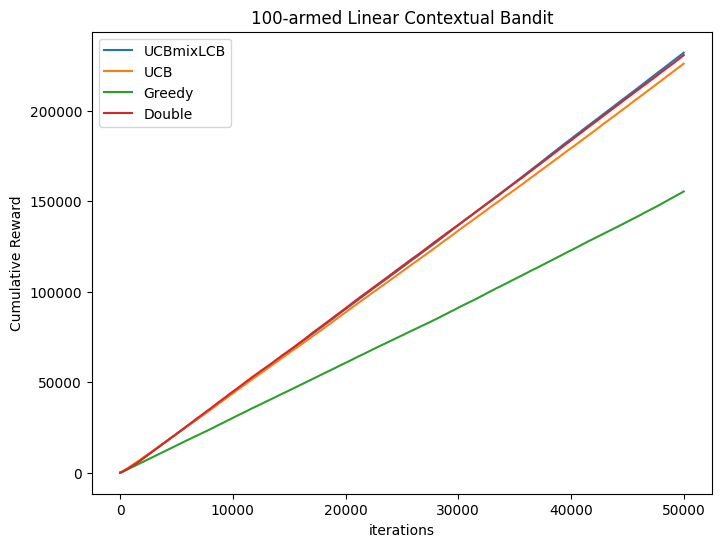

In [31]:
cumsummix = np.cumsum(mixrewards)
cumsumucb = np.cumsum(ucbrewards)
cumsumgreedy = np.cumsum(greedyrewards)

if len(greedyrewards) != len(doublerewards):
    print(f'greedy reward has length {len(greedyrewards)} but double reward has length {len(doublerewards)}')
    doublerewards = doublerewards[:len(greedyrewards)]

cumsumdouble = np.cumsum(doublerewards)

plt.figure(figsize=(8, 6))
plt.plot(cumsummix, label='UCBmixLCB')
plt.plot(cumsumucb, label='UCB')
plt.plot(cumsumgreedy, label='Greedy')
plt.plot(cumsumdouble, label='Double')


plt.legend()
plt.xlabel('iterations')
plt.ylabel('Cumulative Reward')
plt.title(f'{n_arms}-armed Linear Contextual Bandit')

plt.show()